In [151]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent / "src"))

In [152]:
import numpy
from matplotlib import pyplot as plt

In [153]:
import importlib

import pyspell
importlib.reload(pyspell)

<module 'pyspell' from '/Users/harius/wrk/pyspell/src/pyspell/__init__.py'>

In [154]:
def faceroll(world, monk, tank):
    monk.use(pyspell.RenewingMist, tank)
    while True:
        ch = []
        for sp in [pyspell.RisingSunKick, pyspell.BlackoutKick, pyspell.TigerPalm]:
            if monk.ready(sp, tank):
                ch.append(sp)
        if ch:
            sp = world.rng.choice(ch)
            monk.use(sp, tank)
        yield 0.3

        
def simple(world, monk, tank):
    while True:
        for sp in [pyspell.RisingSunKick, pyspell.BlackoutKick, pyspell.TigerPalm]:
            if monk.ready(sp, tank):
                monk.use(sp, tank)
                break
        yield 0.3


def stacking(world, monk, tank):
    while True:
        if monk.ready(pyspell.RisingSunKick, tank):
            monk.use(pyspell.RisingSunKick, tank)
        elif (teachings := world.exists(monk, pyspell.TeachingsOfTheMonastery)) and teachings.stack_size == 3:
            if monk.ready(pyspell.BlackoutKick, tank):
                monk.use(pyspell.BlackoutKick, tank)
        elif monk.ready(pyspell.TigerPalm, tank):
            monk.use(pyspell.TigerPalm, tank)
        yield 0.1

    
def smartass(world, monk, tank):
    while True:
        if monk.ready(pyspell.RisingSunKick, tank):
            monk.use(pyspell.RisingSunKick, tank)
        elif (rsk_cd := world.remaining_time(monk, pyspell.RisingSunKickCooldown)) is not None and rsk_cd < 2.0:
            if monk.ready(pyspell.TigerPalm, tank):
                monk.use(pyspell.TigerPalm, tank)
        elif (teachings := world.exists(monk, pyspell.TeachingsOfTheMonastery)) and teachings.stack_size == 3:
            if monk.ready(pyspell.BlackoutKick, tank):
                monk.use(pyspell.BlackoutKick, tank)
        elif monk.ready(pyspell.TigerPalm, tank):
            monk.use(pyspell.TigerPalm, tank)
        yield 0.3

In [155]:
def sim(script, t):
    world = pyspell.World()

    monk = world.add(pyspell.Character)
    tank = world.add(pyspell.Character)

    world.add_entity(pyspell.Script(script(world, monk, tank)))

    ts = []
    tank_health = []
    monk_health = []
    # TODO: implement healing buff renewals correctly
    # TODO: implement EF
    # TODO: implement mana consumption
    # TODO: implement Rising Mist
    # TODO: implement mana and health regen
    # TODO: implement ability interruption
    # TODO: implement targetless abilities
    # TODO: separate abilities and effects
    # TODO: implement some sane proc ordering (running / addition / deletion order)
    # TODO: timeline visuaization
    while world.t <= t:
        ts.append(world.t)
        tank_health.append(tank.health)
        monk_health.append(monk.health)
        world.tick()
    return ts, tank_health, monk_health

<function faceroll at 0x141079280> 343 dps
<function simple at 0x13f122280> 381 dps
<function stacking at 0x1404c59d0> 377 dps
<function smartass at 0x1409d9e50> 377 dps


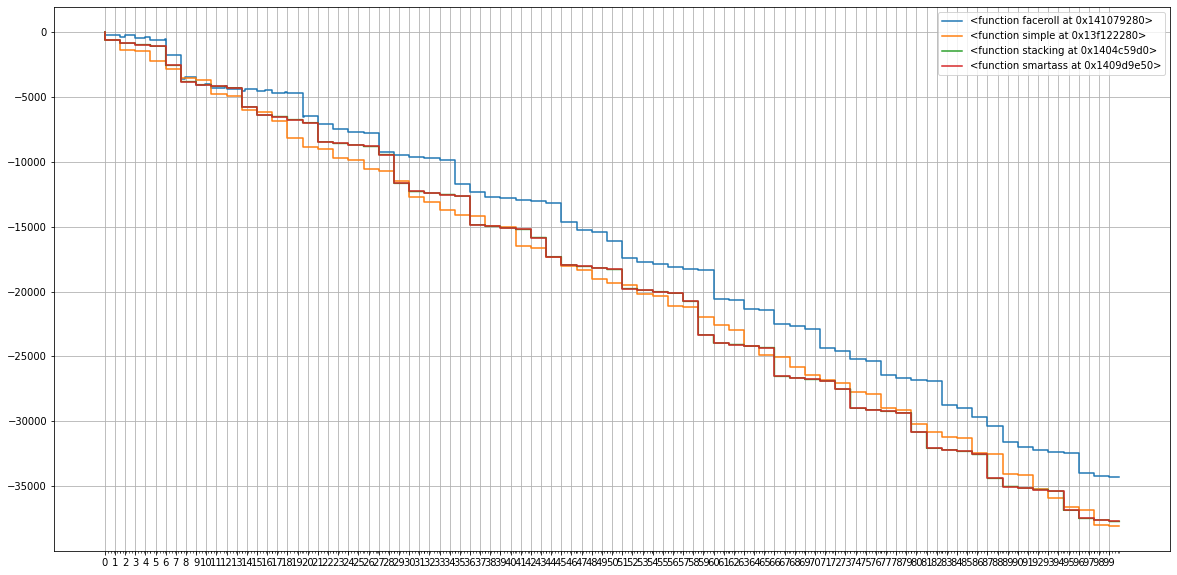

In [156]:
fig = plt.figure(figsize=(20, 10))
t = 100.0
for sc in [faceroll, simple, stacking, smartass]:
    ts, tank_health, monk_health = sim(sc, t)
    plt.step(ts, tank_health, where="post", label=str(sc))
    print(sc, round(-tank_health[-1] / ts[-1]), "dps")
plt.gca().set_xticks(numpy.arange(0.0, t, 1.0))
plt.gca().set_xticks(ts, minor=True)
plt.grid(which="major")
plt.legend()